# 04 – Prediction & Report

Objective: Use best model to predict EV counts by city for a target year; report accuracy and top 10 cities by density proxy.

Inputs: `models/best_model.pkl`, `data/processed/model_ready_city_ev.csv`, `data/processed/city_ev_agg.csv`, `data/processed/model_eval.csv`
Outputs: figures/tables in-notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib


In [2]:
# Resolve paths robustly
CWD = Path.cwd()
# Check if we're in notebooks/ directory or project root
if CWD.name == 'notebooks':
    # We're in notebooks/ directory, go up one level
    BASE_DIR = CWD.parent
else:
    # We're in project root
    BASE_DIR = CWD

MODEL = BASE_DIR / 'models/best_model.pkl'
DF_FEATS = BASE_DIR / 'data/processed/model_ready_city_ev.csv'
DF_AGG = BASE_DIR / 'data/processed/city_ev_agg.csv'
EVAL = BASE_DIR / 'data/processed/model_eval.csv'

if not all(p.exists() for p in [MODEL, DF_FEATS, DF_AGG, EVAL]):
    missing = [p for p in [MODEL, DF_FEATS, DF_AGG, EVAL] if not p.exists()]
    raise FileNotFoundError(f'Missing files: {missing}')

print(f"Current directory: {CWD}")
print(f"Base directory: {BASE_DIR}")
print("Required files found:")
print(f"  - Model: {MODEL} ({MODEL.exists()})")
print(f"  - Features: {DF_FEATS} ({DF_FEATS.exists()})")
print(f"  - Aggregated: {DF_AGG} ({DF_AGG.exists()})")
print(f"  - Evaluation: {EVAL} ({EVAL.exists()})")


Current directory: e:\FDM\PROJECT\NEW\Smart-Charge-Locator\notebooks
Base directory: e:\FDM\PROJECT\NEW\Smart-Charge-Locator
Required files found:
  - Model: e:\FDM\PROJECT\NEW\Smart-Charge-Locator\models\best_model.pkl (True)
  - Features: e:\FDM\PROJECT\NEW\Smart-Charge-Locator\data\processed\model_ready_city_ev.csv (True)
  - Aggregated: e:\FDM\PROJECT\NEW\Smart-Charge-Locator\data\processed\city_ev_agg.csv (True)
  - Evaluation: e:\FDM\PROJECT\NEW\Smart-Charge-Locator\data\processed\model_eval.csv (True)


In [3]:
# Load data and model
best = joblib.load(MODEL)
feats = pd.read_csv(DF_FEATS)
agg = pd.read_csv(DF_AGG)
metrics = pd.read_csv(EVAL)

print(f"Model type: {type(best).__name__}")
print(f"Features data shape: {feats.shape}")
print(f"Aggregated data shape: {agg.shape}")
print(f"Evaluation metrics shape: {metrics.shape}")

print("\nModel evaluation metrics:")
print(metrics.sort_values('r2', ascending=False))


Model type: RandomForestRegressor
Features data shape: (5190, 5)
Aggregated data shape: (821, 4)
Evaluation metrics shape: (3, 3)

Model evaluation metrics:
              model        r2        mae
2      RandomForest  0.959353   9.342170
1             Ridge  0.701039  25.163649
0  LinearRegression  0.701039  25.163656


In [4]:
# Prepare prediction data
latest_year = int(feats['Model Year'].max())
target_year = latest_year  # can change

base = feats[feats['Model Year'] == target_year].copy()
X = base[['Model Year','Prev_Year_EV_Count','Year_Delta']]
base['Pred_EV_Count'] = best.predict(X)

print(f"Target year: {target_year}")
print(f"Prediction data shape: {base.shape}")
print("Sample prediction data:")
base.head()


Target year: 2026
Prediction data shape: (192, 6)
Sample prediction data:


,City,Model Year,EV_Count,Prev_Year_EV_Count,Year_Delta,Pred_EV_Count
14,Aberdeen,2026,1,12.0,26,1.872750
106,Anacortes,2026,10,85.0,26,12.471167
149,Arlington,2026,7,68.0,26,11.665000
186,Auburn,2026,42,256.0,26,32.860000
208,Bainbridge Island,2026,6,185.0,26,13.660000


In [5]:
# Merge with density proxy data
out = base[['City','Pred_EV_Count']].groupby('City', as_index=False).sum()
out = out.merge(agg[['City','EV_Density_Proxy','EV_Count_Total']], on='City', how='left')

print(f"Merged data shape: {out.shape}")
print("Sample merged data:")
out.head()


Merged data shape: (192, 4)
Sample merged data:


,City,Pred_EV_Count,EV_Density_Proxy,EV_Count_Total
0,Aberdeen,1.872750,236.0,236
1,Anacortes,12.471167,950.0,950
2,Arlington,11.665000,175.2,876
3,Auburn,32.860000,587.6,2938
4,Bainbridge Island,13.660000,2260.0,2260


In [6]:
# Top 10 cities by density proxy
top10 = out.sort_values('EV_Density_Proxy', ascending=False).head(10)

print('Top 10 cities by density proxy:')
print(top10[['City','EV_Density_Proxy','Pred_EV_Count']])


Top 10 cities by density proxy:
                  City  EV_Density_Proxy  Pred_EV_Count
106      Mercer Island       2988.000000         21.195
4    Bainbridge Island       2260.000000         13.660
23               Camas       2177.000000         21.305
88        Lake Stevens       2129.000000         15.305
149          Sammamish       1755.250000         97.350
12         Bonney Lake       1532.000000         19.880
7             Bellevue       1525.500000        285.025
143            Redmond       1442.166667        112.605
78             Kenmore       1436.000000         13.275
8           Bellingham       1400.000000         24.405


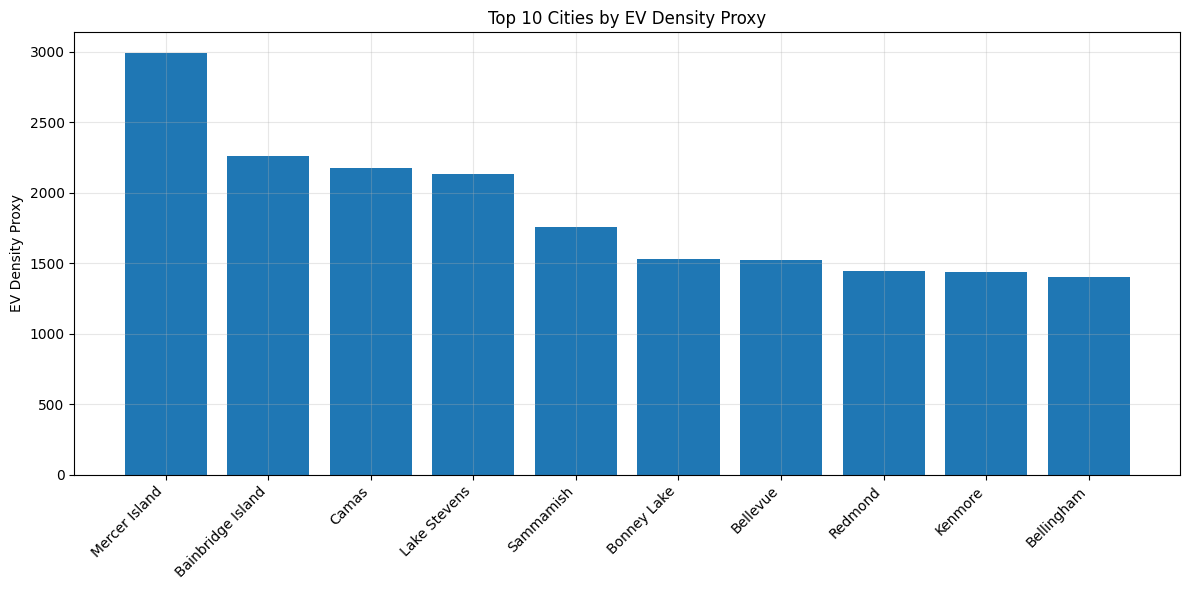

In [7]:
# Create visualization
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(len(top10)), top10['EV_Density_Proxy'])
ax.set_xticks(range(len(top10)))
ax.set_xticklabels(top10['City'], rotation=45, ha='right')
ax.set_ylabel('EV Density Proxy')
ax.set_title('Top 10 Cities by EV Density Proxy')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
# Summary statistics
print("Summary Statistics:")
print(f"Total cities analyzed: {len(out)}")
print(f"Average EV Density Proxy: {out['EV_Density_Proxy'].mean():.2f}")
print(f"Median EV Density Proxy: {out['EV_Density_Proxy'].median():.2f}")
print(f"Max EV Density Proxy: {out['EV_Density_Proxy'].max():.2f}")

print("\nModel Performance Summary:")
best_model_metrics = metrics.sort_values('r2', ascending=False).iloc[0]
print(f"Best Model: {best_model_metrics['model']}")
print(f"R² Score: {best_model_metrics['r2']:.3f}")
print(f"MAE: {best_model_metrics['mae']:.3f}")


Summary Statistics:
Total cities analyzed: 192
Average EV Density Proxy: 410.76
Median EV Density Proxy: 274.33
Max EV Density Proxy: 2988.00

Model Performance Summary:
Best Model: RandomForest
R² Score: 0.959
MAE: 9.342
